# MERMER SINIFLANDIRMA
 * BURDUR_BEJI 
 * BURDUR_ROSALYA 
 * Denizli_Traverten 
 * Eskisehir_Gumus 
 * Mugla_Beyaz
 * MYRA_BEJI

 olmak üzere altı tane mermer taşı türü bulunmaktadır. Bu çalışmada Mermer taşlarının sınıflandırılması amaçlanmıştır. 
 

---

## Drive'ın Mount Edilmesi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Gerekli kütüphanelerin import edilmesi.
* Train, test ve validation veri kümelerinin çekilmesi ve gerekli ön işlemlerin yapılarak oluşturulması.
* Veri setinden birkaç örnek resim sunulması.

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.chdir("/content/drive/MyDrive/EklemeliStones")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.applications import InceptionV3 , mobilenet,mobilenet_v2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5
from keras.preprocessing.image import ImageDataGenerator
from keras import Model 
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D,BatchNormalization
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.applications import resnet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

import seaborn as sns
sns.set_style('darkgrid')

Found 1152 images belonging to 6 classes.
Found 144 images belonging to 6 classes.
Found 334 images belonging to 6 classes.


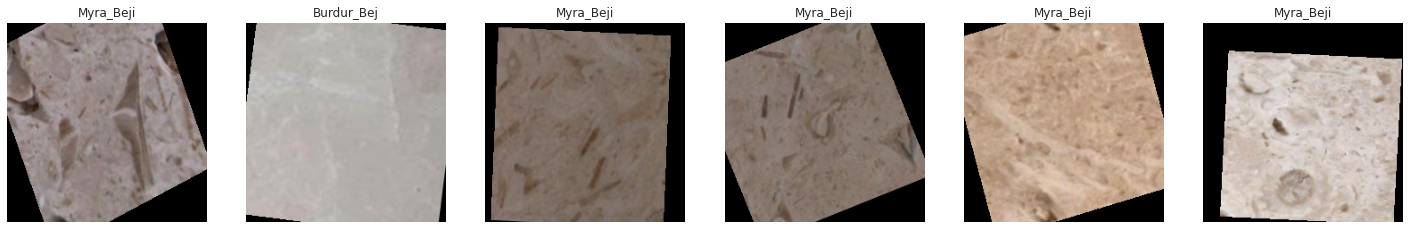

In [ ]:
EPOCHS = 10
train_data_gen = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=35,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

dataset_dir = '/content/drive/MyDrive/EklemeliStones/train'
valid_dr = '/content/drive/MyDrive/EklemeliStones/valid_Mermer'
test_dr = '/content/drive/MyDrive/EklemeliStones/test_Mermer'


Batch_size = 32
img_h = 224
img_w = 224
num_classes=6
classes = ['BURDUR_BEJI','BURDUR_ROSALYA', 'Denizli_Traverten','Eskisehir_Gumus', 'Mugla_Beyaz','MYRA_BEJI']


# Training
SEED = 1234
tf.random.set_seed(SEED) 


train_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               target_size=(224, 224),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

# Validation
valid_gen = valid_data_gen.flow_from_directory(valid_dr,
                                           target_size=(224, 224),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)

test_gen = test_data_gen.flow_from_directory(test_dr,
                                             target_size=(224, 224),
                                             batch_size=1, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )

class_names = np.array(['BURDUR_BEJI','BURDUR_ROSALYA', 'Denizli_Traverten','Eskisehir_Gumus', 'Mugla_Beyaz','MYRA_BEJI'], dtype='<U10')



def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  
  for n in range(0,6):
      ax = plt.subplot(1,6,n+1)
      plt.imshow(image_batch[n])
      plt.title(class_names[label_batch[n]==True][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

In [ ]:
def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    pred_list=[ ] 
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def scoreGraph(history):
  print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def roc_auc(test_gen,model):
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras[:,1], pos_label=1)
  auc_keras = auc(fpr_keras, tpr_keras)
  print("AUC : ",auc_keras)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

# ResNet50 MODELİ
* Modelin yüklenmesi yapılmaktadır. 
* Modelin oluşturulması.
* Modelin derlenmesi.
* ResNet Modeli ile veri kümesinin eğitilmesi.

In [ ]:
def RESNET50():
  # ALTTAKİ SATIRA weights='imagenet' EKLENEREK TRANSFER ÖĞRENME YAPILABİLİR. 
  # DİĞERLERİNE UYGULADIM. 
  resnet50_base = resnet.ResNet50(include_top=False, input_tensor=None, input_shape=(img_h, img_w,3))

  tf.keras.layers.Rescaling(1./255)
  output = resnet50_base.get_layer(index = -1).output  
  output = Flatten()(output)
  output = Dense(512,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(512,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  resnet50_model = Model(resnet50_base.input, output)
  for layer in resnet50_model.layers[:-7]:
      layer.trainable = False
  resnet50_model.summary()
  print(len(resnet50_model.layers))
  resnet50_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size
  
  transfer_learning_history = resnet50_model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks = [callbacks]
                      )        
  
  resnet50_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_resnet50.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_resnet50.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  resnet50_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = resnet50_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(transfer_learning_history)
  cm_cr(test_gen, resnet50_model)
  roc_auc(test_gen, resnet50_model)
        

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

<ipython-input-7-cb45e05ea25b>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = resnet50_model.fit_generator(generator=train_gen,


Epoch 1/10
36/36 [==============================] - 327s 9s/step - loss: 1.2244 - accuracy: 0.7075 - val_loss: 20.7941 - val_accuracy: 0.6250
Epoch 2/10
36/36 [==============================] - 299s 8s/step - loss: 0.6738 - accuracy: 0.8403 - val_loss: 14.6277 - val_accuracy: 0.6250
Epoch 3/10
36/36 [==============================] - 291s 8s/step - loss: 0.6097 - accuracy: 0.8585 - val_loss: 11.4092 - val_accuracy: 0.6250
Epoch 4/10
36/36 [==============================] - 301s 8s/step - loss: 0.5219 - accuracy: 0.8689 - val_loss: 18.7299 - val_accuracy: 0.6250
Epoch 5/10
36/36 [==============================] - 293s 8s/step - loss: 0.4826 - accuracy: 0.8759 - val_loss: 8.7357 - val_accuracy: 0.6250
Epoch 6/10
36/36 [==============================] - 294s 8s/step - loss: 0.4157 - accuracy: 0.8811 - val_loss: 10.6352 - val_accuracy: 0.6250
Epoch 7/10
36/36 [==============================] - 297s 8s/step - loss: 0.3813 - accuracy: 0.8828 - val_loss: 8.6494 - val_accuracy: 0.0078
Epoch 8/

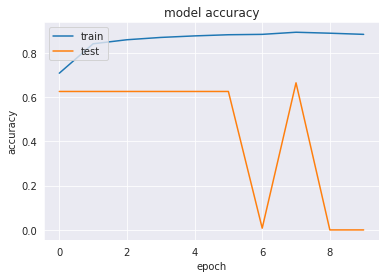

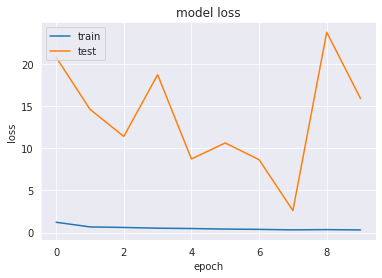

334/334 [==============================] - 124s 371ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
                    precision    recall  f1-score   support

      BURDUR_BEJI       0.00      0.00      0.00        48
    BURSA_ROSALYA       0.00      0.00      0.00        41
DENIZLI_TRAVERTEN       0.00      0.00      0.00        36
  ESKISEHIR_GUMUS       0.16      1.00      0.27        53
      MUGLA_BEYAZ       0.00      0.00      0.00        60
        MYRA_BEJI       0.00      0.00      0.00        96

         accuracy                           0.16       334
        macro avg       0.03      0.17      0.05       334
     weighted avg       0.03      0.16      0.04       334



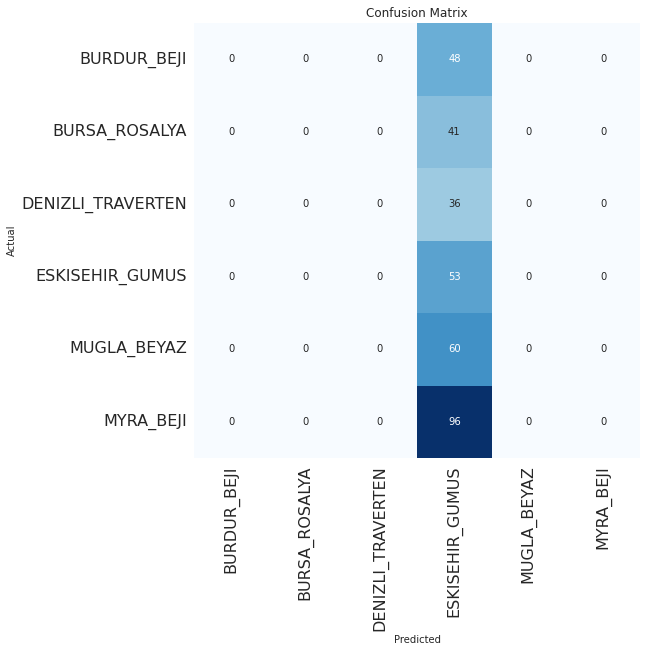

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


334/334 [==============================] - 73s 219ms/step
AUC :  0.5421626571214517


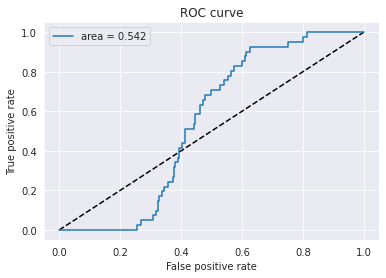

In [ ]:
RESNET50()

# VGG16 MODELİ
* Train, test ve validation veri kümelerinin çekilmesi ve gerekli ön işlemlerin yapılarak oluşturulması.
* VGG modelinin yüklenmesi ve modelin oluşturulması. 
* Modelin derlenip, veri kümesi üzerinde eğitilmesi.

In [ ]:
def VirtualGG16():
  vgg16_base = VGG16(include_top=False, input_tensor=None,weights='imagenet', input_shape=(img_h, img_w,3))

  output = vgg16_base.get_layer(index = -1).output  
  output = Flatten()(output)
  # let's add a fully-connected layer
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  vgg16_model = Model(vgg16_base.input, output)
  for layer in vgg16_model.layers[:-7]:
      layer.trainable = False
  vgg16_model.summary()
  vgg16_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size


  history = vgg16_model.fit_generator(train_gen,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                callbacks = [callbacks]
                                )

  vgg16_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_vgg16.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_vgg16.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  vgg16_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = vgg16_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(history)
  cm_cr(test_gen, vgg16_model)
  roc_auc(test_gen, vgg16_model)

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

<ipython-input-9-954ac79770ca>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg16_model.fit_generator(train_gen,


Epoch 1/10
36/36 [==============================] - 760s 21s/step - loss: 0.6719 - accuracy: 0.8655 - val_loss: 13.0811 - val_accuracy: 0.5486
Epoch 2/10
36/36 [==============================] - 756s 21s/step - loss: 0.3056 - accuracy: 0.9427 - val_loss: 7.8853 - val_accuracy: 0.4236
Epoch 3/10
36/36 [==============================] - 811s 23s/step - loss: 0.1915 - accuracy: 0.9661 - val_loss: 1.2638 - val_accuracy: 0.7847
Epoch 4/10
36/36 [==============================] - 751s 21s/step - loss: 0.1502 - accuracy: 0.9670 - val_loss: 0.8165 - val_accuracy: 0.8472
Epoch 5/10
36/36 [==============================] - 829s 23s/step - loss: 0.1178 - accuracy: 0.9731 - val_loss: 0.1198 - val_accuracy: 0.9653
Epoch 6/10
36/36 [==============================] - 750s 21s/step - loss: 0.1137 - accuracy: 0.9748 - val_loss: 0.1802 - val_accuracy: 0.9514
Epoch 7/10
36/36 [==============================] - 750s 21s/step - loss: 0.0954 - accuracy: 0.9783 - val_loss: 0.3419 - val_accuracy: 0.9236
Epoch

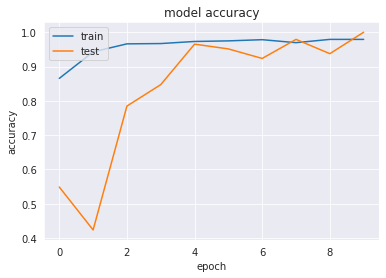

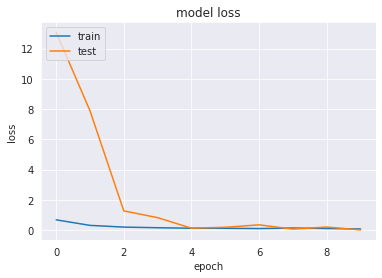

334/334 [==============================] - 190s 569ms/step
Classification Report:
----------------------
                    precision    recall  f1-score   support

      BURDUR_BEJI       0.35      0.96      0.51        48
    BURSA_ROSALYA       0.00      0.00      0.00        41
DENIZLI_TRAVERTEN       0.00      0.00      0.00        36
  ESKISEHIR_GUMUS       0.00      0.00      0.00        53
      MUGLA_BEYAZ       0.00      0.00      0.00        60
        MYRA_BEJI       0.48      1.00      0.65        96

         accuracy                           0.43       334
        macro avg       0.14      0.33      0.19       334
     weighted avg       0.19      0.43      0.26       334



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


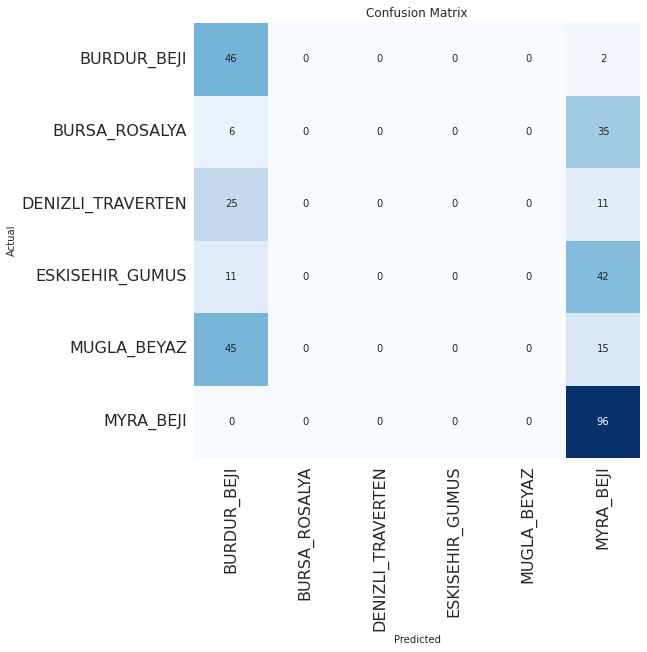

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


334/334 [==============================] - 191s 571ms/step
AUC :  0.43977357862315825


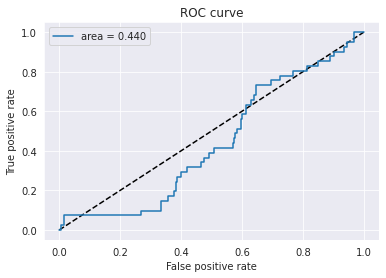

In [ ]:
VirtualGG16()

# INCEPTION MODELİ
* Modelin yüklenmesi ve oluşturulması.
* Modelin derlenmesi ve veri kümesi üzerinde modelin eğitilmesi.

In [ ]:
def INCEPTIONV3():

  inception_model = InceptionV3(include_top=False, input_tensor=None,weights='imagenet', input_shape=(img_h, img_w,3))

  output = inception_model.get_layer(index = -1).output  
  output = Flatten()(output)
  # let's add a fully-connected layer
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  inception_model = Model(inception_model.input, output)
  for layer in inception_model.layers[:-7]:
      layer.trainable = False
  inception_model.summary()
  inception_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size

  history = inception_model.fit_generator(train_gen,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                callbacks = [callbacks]
                                )
  inception_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_inception.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_inception.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  inception_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = inception_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(history)
  cm_cr(test_gen, inception_model)
  roc_auc(test_gen, inception_model)
      

87910968/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 rmalization)              

<ipython-input-11-556fa282c608>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = inception_model.fit_generator(train_gen,


Epoch 1/10
36/36 [==============================] - 211s 6s/step - loss: 0.4049 - accuracy: 0.8811 - val_loss: 1.2531 - val_accuracy: 0.7986
Epoch 2/10
36/36 [==============================] - 194s 5s/step - loss: 0.1711 - accuracy: 0.9661 - val_loss: 0.3649 - val_accuracy: 0.9028
Epoch 3/10
36/36 [==============================] - 192s 5s/step - loss: 0.1264 - accuracy: 0.9679 - val_loss: 0.4473 - val_accuracy: 0.9444
Epoch 4/10
36/36 [==============================] - 199s 6s/step - loss: 0.1394 - accuracy: 0.9696 - val_loss: 0.2179 - val_accuracy: 0.9653
Epoch 5/10
36/36 [==============================] - 191s 5s/step - loss: 0.1557 - accuracy: 0.9661 - val_loss: 0.1086 - val_accuracy: 0.9792
Epoch 6/10
36/36 [==============================] - 194s 5s/step - loss: 0.1434 - accuracy: 0.9696 - val_loss: 0.2649 - val_accuracy: 0.9653
Epoch 7/10
36/36 [==============================] - 194s 5s/step - loss: 0.1255 - accuracy: 0.9731 - val_loss: 0.3146 - val_accuracy: 0.9583
Epoch 8/10
36

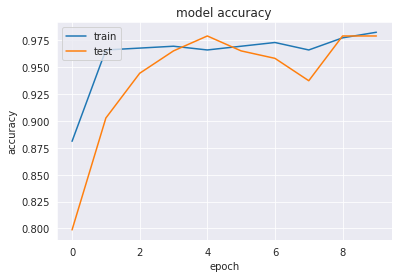

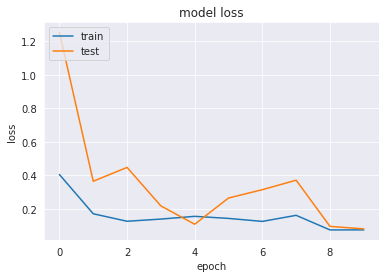

334/334 [==============================] - 55s 165ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
                    precision    recall  f1-score   support

      BURDUR_BEJI       0.26      0.90      0.41        48
    BURSA_ROSALYA       0.00      0.00      0.00        41
DENIZLI_TRAVERTEN       0.00      0.00      0.00        36
  ESKISEHIR_GUMUS       0.00      0.00      0.00        53
      MUGLA_BEYAZ       0.00      0.00      0.00        60
        MYRA_BEJI       0.56      1.00      0.72        96

         accuracy                           0.42       334
        macro avg       0.14      0.32      0.19       334
     weighted avg       0.20      0.42      0.27       334



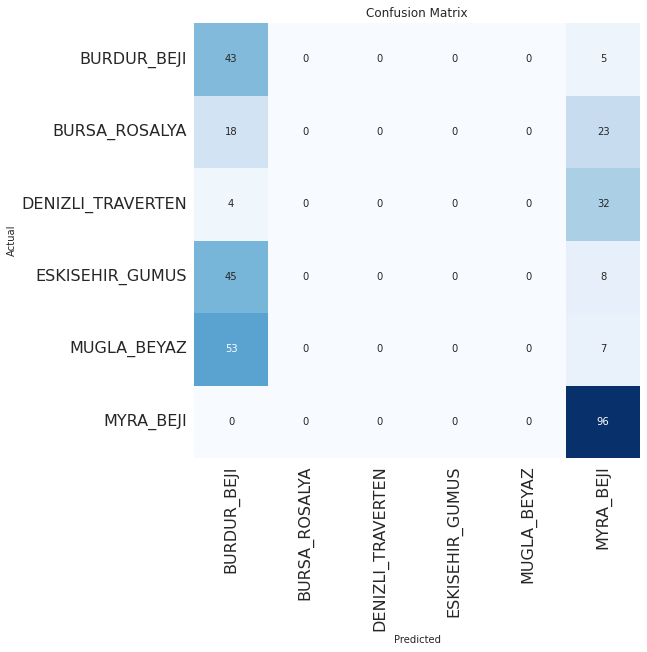

<ipython-input-6-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


334/334 [==============================] - 55s 165ms/step
AUC :  0.6715225172729544


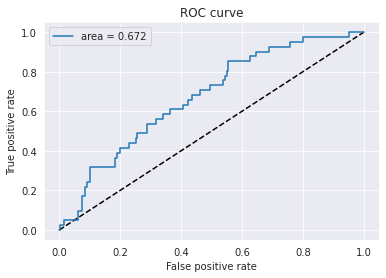

In [ ]:
INCEPTIONV3()

# EfficentNet MODELİ
* Modelin yüklenmesi ve oluşturulması.
* Modelin derlenmesi ve veri kümesi üzerinde eğitilmesi.

In [ ]:
def EFFICIENTNET():
# EfficientNet yüklemesi
  efficent_model=EfficientNetB3(include_top=False, input_tensor=None,weights='imagenet', input_shape=(img_h, img_w,3))

  output = efficent_model.get_layer(index = -1).output  
  output = Flatten()(output)
  # let's add a fully-connected layer
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(1024,activation = "relu")(output)
  output = BatchNormalization()(output)
  output = Dropout(0.2)(output)
  output = Dense(6, activation='softmax')(output)
  efficent_model = Model(efficent_model.input, output)
  for layer in efficent_model.layers[:-7]:
      layer.trainable = False
  efficent_model.summary()
  efficent_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=2, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=2) #min_lr=0.0000001

  STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
  STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size
  STEP_SIZE_TEST  = test_gen.n//test_gen.batch_size


  callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
  reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=1)

  history = efficent_model.fit_generator(train_gen,
                                epochs=EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                callbacks = [callbacks]
                                )

  efficent_model.save("/content/drive/MyDrive/EklemeliStones/cimstone_efficent.h5")  
  # VAROLAN EĞİTİLMİŞ BİR MODEL YÜKLENMEK İSTENİRSE
  #from keras.models import load_model
  #model_new = load_model("/content/drive/MyDrive/EklemeliStones/cimstone_efficent.h5")
  #model_new.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  #pred = model_new.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)     
  # MEVCUT YUKARIDA EĞİTİLEN MODEL İLE DEVAM ETMEK İSTENİRSE
  efficent_model.evaluate(valid_gen, steps=valid_gen.n//valid_gen.batch_size,verbose=1)
  pred = efficent_model.predict(test_gen,steps=test_gen.n//valid_gen.batch_size,verbose=1)
  # YENİ EĞİTİLEN MODELİN HISTORYSİNE BAKARAK GRAFİK OLUŞTURULUR.
  scoreGraph(history)
  cm_cr(test_gen, efficent_model)
  roc_auc(test_gen, efficent_model)
      

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [ ]:
# TF_Version hatası kronik bir keras sorunu. Çözüm için :
# https://github.com/keras-team/keras/issues/17199
"""
Got the exact same issue with TF 2.10 and TF 2.11 (tried to save model in saved_model format and in H5 format, neither worked).
Downgrading to TF2.9 helped for now but it would be really nice to be able to use TF more recent versions' features
"""
# YÜKLENDİKTEN SONRA RESTART RUNTIME YAPILMALI SADECE EFFICIENT NET ÇALIŞTIRILMALI !!!
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


43941136/43941136 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)

<ipython-input-9-0992702cb6dc>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = efficent_model.fit_generator(train_gen,


Epoch 1/10
36/36 [==============================] - 481s 13s/step - loss: 2.0173 - accuracy: 0.4028 - val_loss: 51.3979 - val_accuracy: 0.3333
Epoch 2/10
36/36 [==============================] - 19s 531ms/step - loss: 1.2120 - accuracy: 0.6033 - val_loss: 6.1581 - val_accuracy: 0.3333
Epoch 3/10
36/36 [==============================] - 19s 525ms/step - loss: 0.9352 - accuracy: 0.6727 - val_loss: 3.3410 - val_accuracy: 0.3125
Epoch 4/10
36/36 [==============================] - 19s 526ms/step - loss: 0.8104 - accuracy: 0.6858 - val_loss: 11.8959 - val_accuracy: 0.6667
Epoch 5/10
36/36 [==============================] - 20s 548ms/step - loss: 0.7588 - accuracy: 0.6910 - val_loss: 3.5093 - val_accuracy: 0.6667
Epoch 6/10
36/36 [==============================] - 19s 524ms/step - loss: 0.7068 - accuracy: 0.6840 - val_loss: 5.3918 - val_accuracy: 0.6667
Epoch 7/10
36/36 [==============================] - 19s 523ms/step - loss: 0.6524 - accuracy: 0.7405 - val_loss: 6.5619 - val_accuracy: 0.333

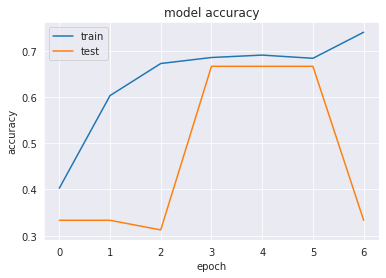

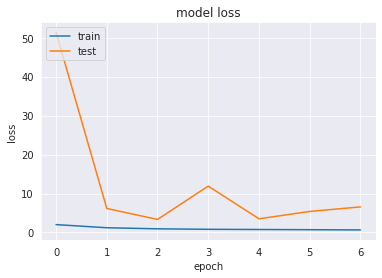

334/334 [==============================] - 274s 822ms/step
Classification Report:
----------------------
                    precision    recall  f1-score   support

      BURDUR_BEJI       0.14      1.00      0.25        48
    BURSA_ROSALYA       0.00      0.00      0.00        41
DENIZLI_TRAVERTEN       0.00      0.00      0.00        36
  ESKISEHIR_GUMUS       0.00      0.00      0.00        53
      MUGLA_BEYAZ       0.00      0.00      0.00        60
        MYRA_BEJI       0.00      0.00      0.00        96

         accuracy                           0.14       334
        macro avg       0.02      0.17      0.04       334
     weighted avg       0.02      0.14      0.04       334



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


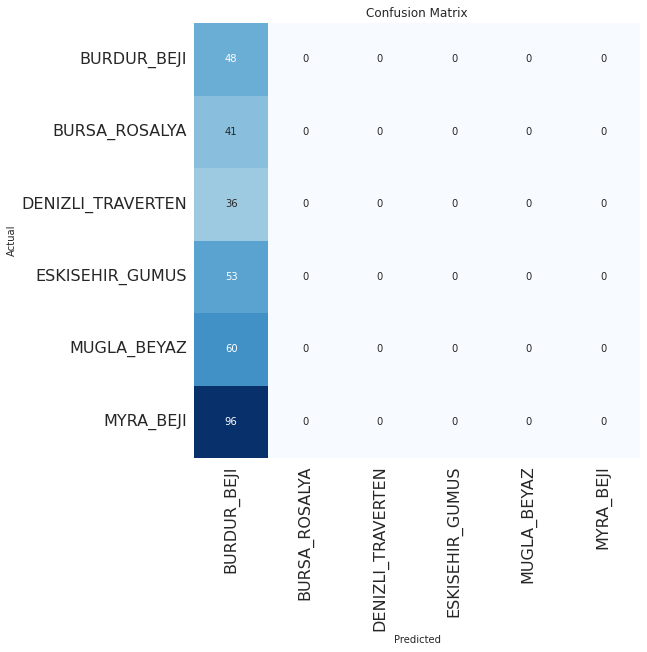

<ipython-input-7-8b09217d3068>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=STEP_SIZE_TEST, verbose=1)


334/334 [==============================] - 10s 31ms/step
AUC :  0.7652543078331807


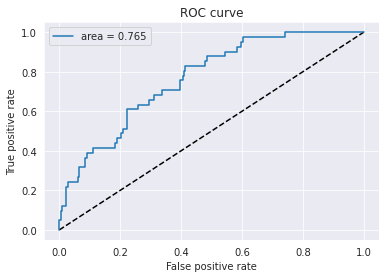

In [ ]:
EFFICIENTNET()